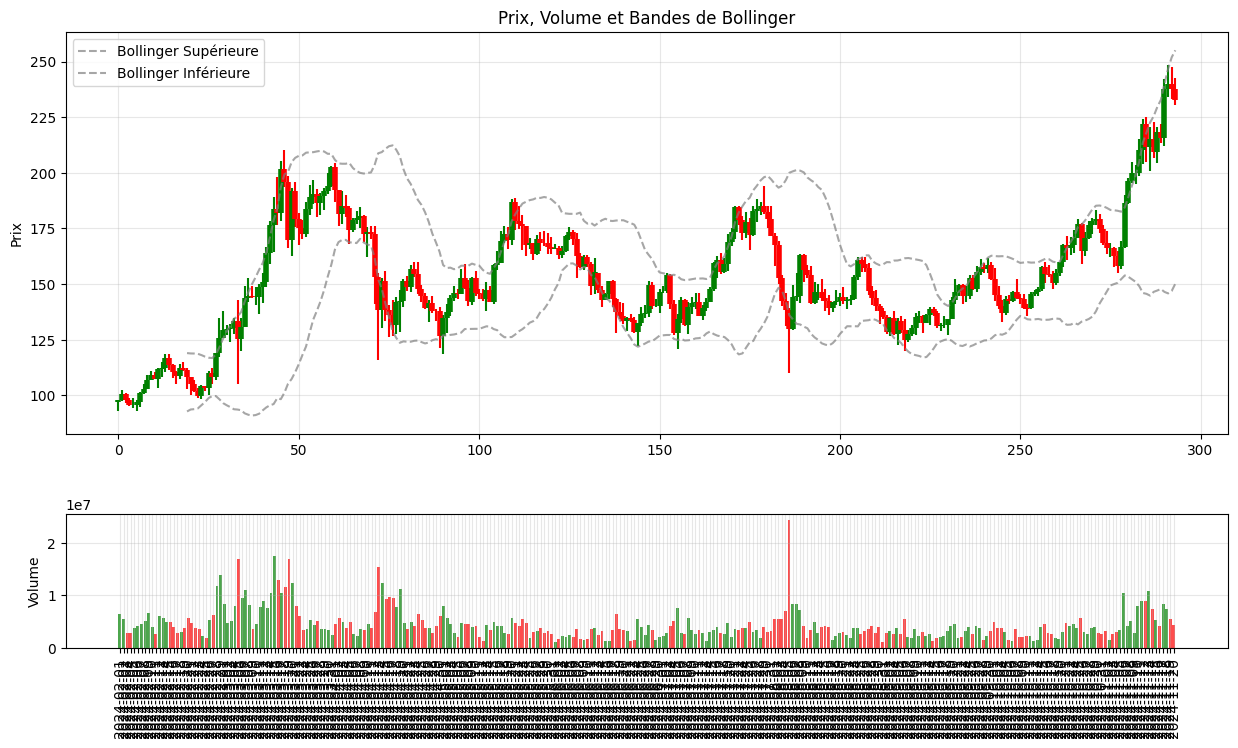

In [1]:
from src.mtal.data_collect import (
    get_pair_df,
    get_spot_pairs,
    get_stock_data,
    get_ticker_names,
)
from src.mtal.analysis import compute_BB
from src.mtal.dataviz import plot_price_history
import polars as pl

df = get_pair_df(
            pair="SOLUSDT",
            # pair="TRXUSDT",
            # pair="DOGEUSDT",
            # pair="WIFUSDT",
            # pair="AAVEUSDT",
            limit=300,
            frequency="1d",
            # start_time="01/05/24",
            start_time="01/02/24",
        )
df = df.with_columns(pl.Series(name="idx", values=range(len(df))))
df = compute_BB(df) 
plot_price_history(df, limit=len(df))

In [7]:
df = df[:-10]

{'resistance_level': 196.35, 'setup_size': 224, 'touches': 3, 'breakout_volume_ratio': 1.805683150347115, 'pivot': 280, 'begin': 59, 'end': 283}


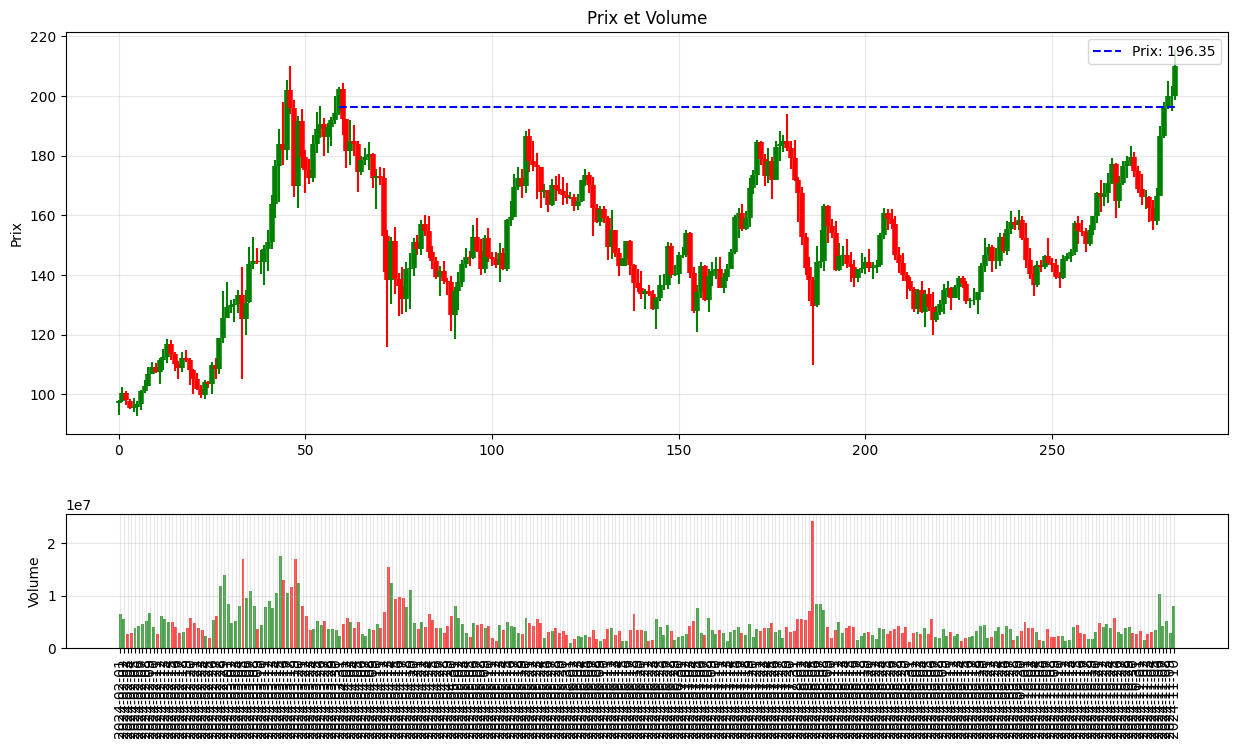

In [8]:
from src.mtal.froment.tasse_hanse import detect_tasse_hanse
best_setup = detect_tasse_hanse(df)

print(best_setup)

    

if best_setup:
    plot_price_history(df, price=best_setup['resistance_level'], start_idx=best_setup['begin'], end_idx=best_setup['end'], limit=len(df))

{'resistance_level': 184.9, 'setup_size': 220, 'touches': 9, 'breakout_volume_ratio': 1.1487155961323412, 'pivot': 178, 'begin': 60, 'end': 280}
{'resistance_level': 184.49, 'setup_size': 220, 'touches': 10, 'breakout_volume_ratio': 1.1487155961323412, 'pivot': 171, 'begin': 60, 'end': 280}
{'resistance_level': 182.57, 'setup_size': 220, 'touches': 10, 'breakout_volume_ratio': 1.1487155961323412, 'pivot': 179, 'begin': 60, 'end': 280}


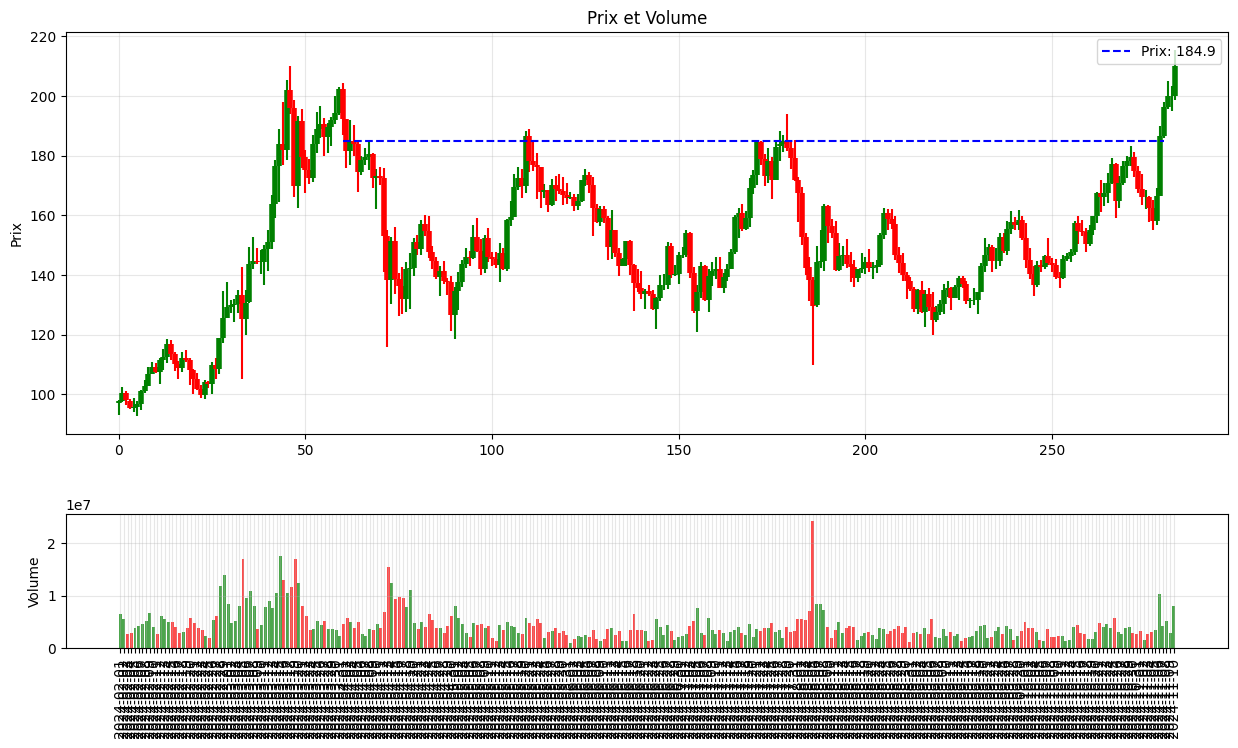

In [12]:
from src.mtal.froment.tasse_hanse import detect_tasse_hanse
import polars as pl

TOLERANCE_THRESHOLD = 0.03

def detect_tasse_hanse(df: pl.DataFrame):
    df = df.with_columns([
        pl.col("Close").rolling_max(window_size=10).alias("local_high")
    ]) 
    
    potential_setups = []
    top_levels = df["local_high"].unique().sort(descending=True).head(20)[1:]
    
    for resistance_level in top_levels:
        # Point pivot (fin de la tasse)
        pivot_idx = df.filter(
            pl.col("Close") == resistance_level
        )[0, "Close Time"]
        tolerance = resistance_level * TOLERANCE_THRESHOLD
        
        potential_touches = df.filter(
            ((pl.col("Close") >= resistance_level - tolerance) &
            (pl.col("Close") <= resistance_level + tolerance)) |
            ((pl.col("High") >= resistance_level - tolerance) &
            (pl.col("High") <= resistance_level + tolerance))
        ).select("Close Time", "Close", "Volume", "idx")

        # If we have one close above the resistance, we remove all the touches before this close time
        for row in df.sort("Close Time", descending=True).iter_rows(named=True):
            if row["Close"] > resistance_level + tolerance and row["Close Time"] < pivot_idx:
                # Filtrer les touches pour ne garder que celles après cette barre
                potential_touches = potential_touches.filter(pl.col("Close Time") > row["Close Time"])
                
                # Ajouter cette barre comme premier touch
                new_touch = pl.DataFrame({
                    "Close Time": [row["Close Time"]],
                    "Close": [row["Close"]],
                    "Volume": [row["Volume"]],
                    "idx": [row["idx"]]
                    },
                    schema={
                        "Close Time": pl.Datetime("ms"),
                        "Close": pl.Float64,
                        "Volume": pl.Float64,
                        "idx": pl.Int64
                    }
                )
                potential_touches = pl.concat([new_touch, potential_touches])
                break

        last_touch_idx = None
        BARS_BETWEEN_TOUCHES = 3  # Nombre de barres minimum entre chaque touche

        filtered_touches = []
        for row in potential_touches.iter_rows(named=True):
            if last_touch_idx is None or (row["idx"] - last_touch_idx) > BARS_BETWEEN_TOUCHES:
                filtered_touches.append(row)
                last_touch_idx = row["idx"]

        touches = pl.DataFrame(filtered_touches)
                    

        if len(touches) < 2:
            continue
            
        first_touch_idx = df.filter(pl.col("Close Time") == touches[0, "Close Time"])["idx"].item()
        first_touch_price = touches[0, "Close"]

        # Calculer la moyenne des prix avant le premier touch
        pre_touch_avg = df.filter(
            pl.col("idx") < first_touch_idx
        )["Close"].mean()

        # Vérifier que la moyenne précédente est inférieure au premier touch
        if pre_touch_avg >= first_touch_price:
            continue

        # Données de la tasse (avant le pivot)
        cup_data = df.filter(
            (pl.col("Close Time") >= touches[0, "Close Time"]) &
            (pl.col("Close Time") <= pivot_idx)
        )
        max_cup_distance = abs(resistance_level - cup_data["Close"].min())
        
        # Données de la hanse (après le pivot)
        handle_data = df.filter(pl.col("Close Time") > pivot_idx)
        if len(handle_data) == 0:
            continue
            

        breakout_point = handle_data.filter(
            pl.col("Close") > resistance_level + tolerance
        )[0]
        
            
        handle_distance = abs(resistance_level - handle_data["Close"].min())
        
        # Vérifier que la distance max de la tasse est plus grande que celle de la hanse
        if max_cup_distance * 1.2 <= handle_distance :
            continue
            
        # Vérifier le volume au breakout
        
        first_touch_idx = df.filter(pl.col("Close Time") == touches[0, "Close Time"])["idx"].item()
        pivot_bar_idx = df.filter(pl.col("Close Time") == pivot_idx)["idx"].item()


        tasse_length = pivot_bar_idx - first_touch_idx
        if len(breakout_point) > 0:
            breakout_bar_idx = df.filter(pl.col("Close Time") == breakout_point[0, "Close Time"])["idx"].item()
            avg_volume = df[breakout_bar_idx-20:breakout_bar_idx, "Volume"].mean()

            breakout_volume_ratio = breakout_point[0, "Volume"] / avg_volume
            if breakout_volume_ratio < 1:
                continue
            hanse_length = breakout_bar_idx - pivot_bar_idx
            end = breakout_bar_idx
        else:
            breakout_bar_idx = None
            hanse_length = df[-1, "idx"] - pivot_bar_idx
            breakout_volume_ratio = 0
            end = df[-1, "idx"]
        if tasse_length > hanse_length and hanse_length > 3:
            potential_setups.append({
                'resistance_level': resistance_level,
                'setup_size': tasse_length + hanse_length,
                'touches': len(touches),
                'breakout_volume_ratio': breakout_volume_ratio,
                'pivot': pivot_bar_idx,
                'begin': first_touch_idx,
                'end': end 
            })
    
    if not potential_setups:
        return False

    for setup in potential_setups:
        print(setup)

    best_setup = max(potential_setups, key=lambda x: x['resistance_level'])
    return best_setup

best_setup = detect_tasse_hanse(df)
if best_setup:
    plot_price_history(df, price=best_setup['resistance_level'], start_idx=best_setup['begin'], end_idx=best_setup['end'], limit=len(df))


In [14]:
from pathlib import Path

test_data_path = Path("tests/data")
output_path = test_data_path / f"solusdt_volume_data.parquet"
df.write_parquet(output_path)

In [21]:
import os
from pathlib import Path

# Créer le dossier tests/data s'il n'existe pas
test_data_path = Path("tests/data")
test_data_path.mkdir(parents=True, exist_ok=True)

# Liste des paires à sauvegarder
pairs = ["SOLUSDT", "TRXUSDT", "DOGEUSDT", "WIFUSDT", "AAVEUSDT"]

# Paramètres communs
params = {
    "limit": 300,
    "frequency": "1d",
    "start_time": "01/05/24"
}

# Sauvegarder chaque paire
for pair in pairs:
    df = get_pair_df(pair=pair, **params)
    
    # Ajouter l'index
    df = df.with_columns(pl.Series(name="idx", values=range(len(df))))
    
    # Sauvegarder en format parquet
    output_path = test_data_path / f"{pair.lower()}_data.parquet"
    df.write_parquet(output_path)
    
    print(f"Saved {pair} data to {output_path}")

Saved SOLUSDT data to tests/data/solusdt_data.parquet
Saved TRXUSDT data to tests/data/trxusdt_data.parquet
Saved DOGEUSDT data to tests/data/dogeusdt_data.parquet
Saved WIFUSDT data to tests/data/wifusdt_data.parquet
Saved AAVEUSDT data to tests/data/aaveusdt_data.parquet
